In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from stochastic.processes.continuous import FractionalBrownianMotion
import stochastic.processes as sto 

In [2]:


def ols_univariate(X, y):
    """
    Computes the OLS regression coefficients for a univariate time series.
    
    Parameters:
    X (numpy.ndarray): 1D array of input features.
    y (numpy.ndarray): 1D array of target values.

    Returns:
    tuple: A tuple containing the intercept and slope of the OLS regression.
    float: Execution time in seconds.
    """
    # Start time
    
    # Add a column of ones to X for the intercept
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    
    # Compute OLS coefficients using the normal equation
    theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
    
    # End time
    
    # Extract coefficients
    intercept, slope = theta_best
    


    
    return intercept + slope * X 

[80, 165, 315, 405, 640, 775, 1001]
0.29715688322434475


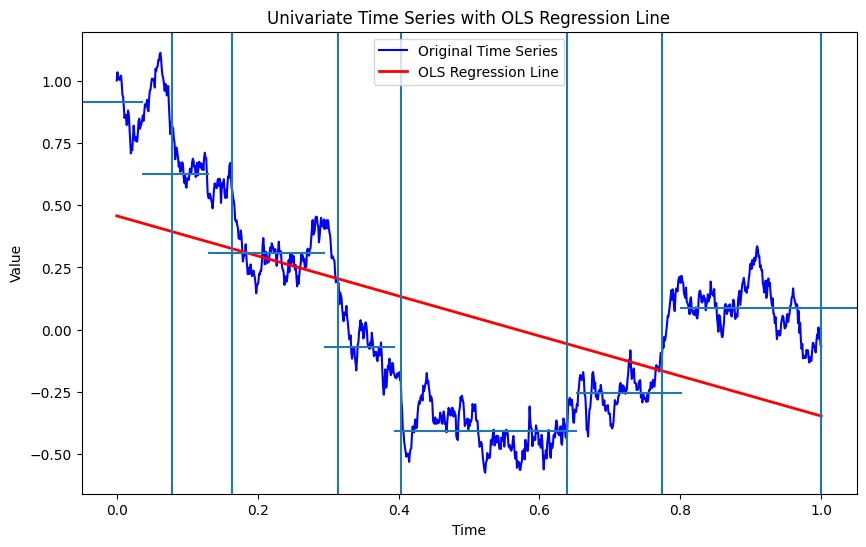

In [3]:
#fbm =  FractionalBrownianMotion(hurst=0.7, t=1)
fbm = sto.DiffusionProcess()
s = fbm.sample(1000)
times = fbm.times(1000)

lin = ols_univariate(times,s)
#plt.figure("aab",figsize=(10, 6))
#plt.plot(times,s)
#plt.plot(times,lin)
#s -= lin
import ruptures as rpt

# detection
algo = rpt.Binseg(model="rbf").fit(s)
result = algo.predict(pen=10)
print(result)
# display
print(np.mean(np.sqrt((lin-s)**2)))

# Plotting the time series and the regression line
plt.figure("aa",figsize=(10, 6))
plt.plot(times, s, label='Original Time Series', color='blue')
plt.plot(times, lin, label='OLS Regression Line', color='red', linewidth=2)
#plt.axhline(0)
plt.xlabel('Time')
plt.ylabel('Value')
for i in range(len(result)):
    if i == 0:
        t_index = times[:result[i]-1]
        s_index = s[:result[i]-1] 
    else:
        t_index = times[result[i-1]-1:result[i]-1]
        s_index = s[result[i-1]-1:result[i]-1]
    #linx = ols_univariate(t_index,s_index)
    #plt.plot(t_index,linx)

    linx = np.mean(s_index)
    plt.axhline(linx, xmin=t_index[0],xmax=t_index[-1])
    plt.axvline(times[result[i]-1])
plt.title('Univariate Time Series with OLS Regression Line')
plt.legend()

plt.show()


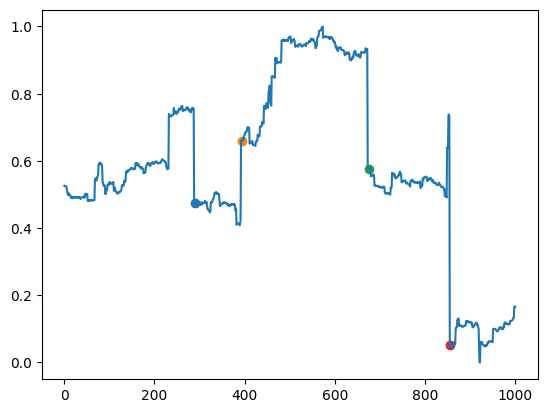

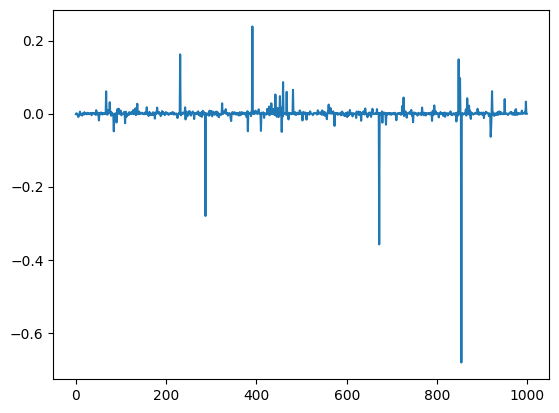

In [3]:
import numpy as np
import pandas as pd


class FindJump:
    def __init__(self,
                time_series:np.ndarray,
                window_size:int = 16,
                ):
        self.time_series = time_series
        self.time_series = self._normalize(time_series)
        self.window_size = window_size 

    @staticmethod    
    def rolling_mean_std(time_series: np.ndarray, span_window=10):
        ewm = pd.Series(time_series).ewm(span=span_window, adjust=False)
        mean = ewm.mean().iat[-1]
        std = ewm.std().bfill().iat[-1]
        return mean, std

    def jump_metric(self, current_price:float, last_mean:float,last_std:float):
        last_std = 0.00001 if last_std==0.0 else last_std
        dist = (current_price-last_mean)**2 / 2*last_std**2
        return dist

    def is_jump(self,time_series:np.ndarray, threshold_jump=1e-4) -> bool:
        # drop last data for mean and std
        last_mean, last_std = self.rolling_mean_std(time_series[:-1],self.window_size)
           
        dist=self.jump_metric(time_series[-1],last_mean,last_std)
        if dist > threshold_jump:
            return True
        else:
            return False

    def _normalize(self,time_series:np.ndarray) -> np.ndarray:
        time_series -= np.min(time_series)
        time_series /= np.max(time_series) - np.min(time_series)
        return time_series

    def jump_detection(self) -> dict:
        jump_dict = {}
        time_series = self.time_series  
        window_size = self.window_size
        i = window_size
        while i < len(time_series):
            ts = time_series[i-window_size:i]
            if self.is_jump(ts):
                jump_dict[i] = ts[-1]
                i += window_size  # Shift i by window_size to skip
            else:
                i += 1  # Increment by 1 if no jump is detected
        return jump_dict


import matplotlib.pyplot as plt
import stochastic.processes as sto 
fbm = sto.CauchyProcess()
ts = fbm.sample(1000)
#times = fbm.times(1000)
df = pd.DataFrame(ts, columns=['Value'])

findJump= FindJump(ts,window_size=32)
jumps=findJump.jump_detection()
plt.figure("aa")
for key , val in jumps.items():
    plt.scatter(x=key,y=val)
plt.plot(findJump.time_series)
plt.figure("bb")
plt.plot(np.diff(findJump.time_series))
plt.show()